# Brain State Classification with SVM
William Yu

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib

## Test Images

In [2]:
# read in initial data
test_path = 'sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii'
brain_test = np.asanyarray(nib.load(test_path).dataobj)

In [3]:
# label 1 means Rest (fixation) which has 94 volumes
# label 2 means Finger movement which has 30 volumes
# label 3 means Lips movement which has 30 volumes
#label 4 means Foot movement which has 30 volumes
mat = scipy.io.loadmat('label.mat')
label = mat['label']
brain = np.array(brain_test)

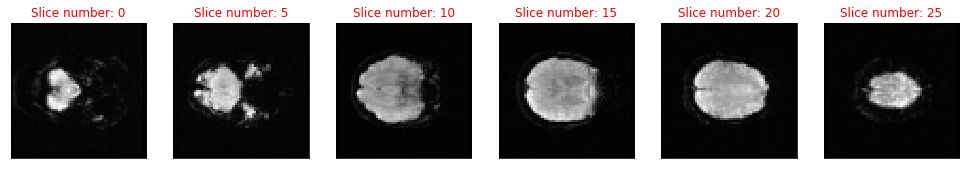

In [4]:
# visualize the brain slices of an observation
# cited from https://medium.com/coinmonks/visualizing-brain-imaging-data-fmri-with-python-e1d0358d9dba
def plot_slices(brain, idx):
    fig, ax = plt.subplots(1, 6, figsize=[17, 3])
    test = brain[: ,:, :, idx]

    n = 0
    slce = 0
    for _ in range(6):
        ax[n].imshow(test[:, :, slce], 'gray')
        ax[n].set_xticks([])
        ax[n].set_yticks([])
        ax[n].set_title('Slice number: {}'.format(slce), color='r')
        n += 1
        slce += 5

    plt.show()
    
plot_slices(brain_test, 20)

In [5]:
# apply binary mask that removes non-brain voxels
# brain_df will be used for testing and training
brain_df = pd.DataFrame()
brain_masked = brain_test.copy()
for i in range(184):
    data = brain_masked[:, :, :, i]
    mask = np.ones((64, 64, 30), dtype=np.int16)
    for j in range(30):
        img = data[:, :, j].copy()
        img[img <= 120] = 0
        img[img > 120] = 1
        mask[:, :, j] = img
    brain_masked[:, :, :, i] = mask
    row = brain_masked[:, :, :, i].flatten()
    brain_df = brain_df.append(pd.Series(row), ignore_index=True)
brain_df.shape

(184, 122880)

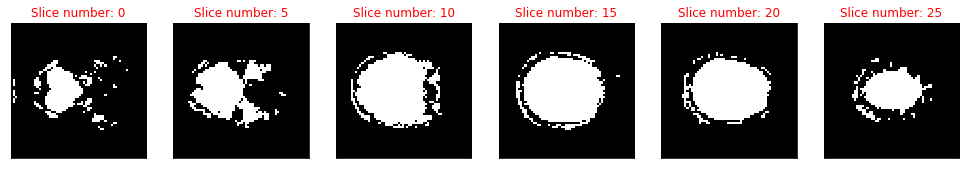

In [6]:
# visualize brain with mask applied
plot_slices(brain_masked, 20)

In [7]:
# extract key brain features by setting variance threshold
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold()
vt.fit(brain_df)
brain_df = brain_df.loc[:, vt.variances_ > 0.08]
brain_df.shape

(184, 5343)

In [8]:
# using k-fold cross validation to train and evaluate model
# 20 splits
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, KFold

svm = LinearSVC(max_iter=30000, random_state=0, penalty='l2', C=0.04)
y = pd.Series(label.flatten())
np.mean(cross_val_score(svm, brain_df, y, cv=KFold(20,shuffle=True, random_state=0)))

0.8916666666666668

## Retest Images

In [9]:
# using same label
retest_path = 'sub-01/ses-retest/func/sub-01_ses-retest_task-fingerfootlips_bold.nii'
brain_retest = np.asanyarray(nib.load(retest_path).dataobj)

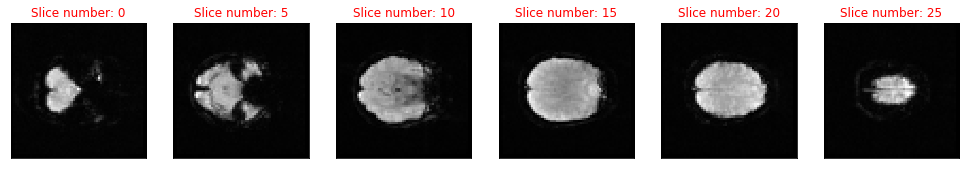

In [10]:
plot_slices(brain_retest, 20)

In [11]:
brain_retest_df = pd.DataFrame()
brain_retest_masked = brain_retest.copy()
for i in range(184):
    data_retest = brain_retest_masked[:, :, :, i]
    mask_retest = np.ones((64, 64, 30), dtype=np.int16)
    for j in range(30):
        img_retest = data_retest[:, :, j].copy()
        img_retest[img_retest <= 120] = 0
        img_retest[img_retest > 120] = 1
        mask_retest[:, :, j] = img_retest
    brain_retest_masked[:, :, :, i] = mask_retest
    row = brain_retest_masked[:, :, :, i].flatten()
    brain_retest_df = brain_retest_df.append(pd.Series(row), ignore_index=True)
brain_retest_df.shape

(184, 122880)

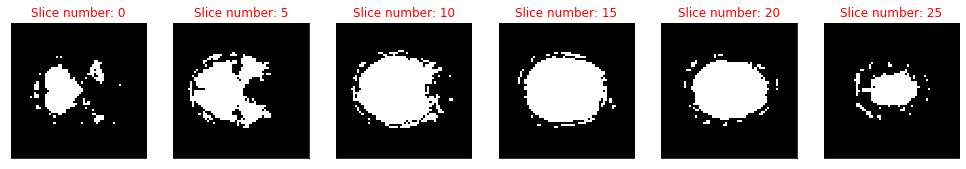

In [12]:
plot_slices(brain_retest_masked, 20)

In [13]:
vt = VarianceThreshold()
vt.fit(brain_retest_df)
brain_retest_df = brain_retest_df.loc[:, vt.variances_ > 0.16]
brain_retest_df.shape

(184, 2034)

In [14]:
svm = LinearSVC(max_iter=30000, random_state=0, penalty='l2', C=0.04)
np.mean(cross_val_score(svm, brain_retest_df, y, cv=KFold(21,shuffle=True, random_state=0)))

0.853174603174603